# Gradient Boosting  Activity
***

## Table of Contents
1. Airline Flights Dataset
2. Clean Data & Examine Target Feature
3. Split Train/Test Set
4. Build a Boosting Ensemble from Scratch
5. Examine Learning Curve & Explain Individual Hyperparameter Effects
    - max_depth
    - learning_rate
    - min_child_weight
    - n_estimators
6. Examine & Perform GridSearchCV 
7. Plot Learning Curve
8. Explain & Perform Early Stopping (How to Prevent Overfitting)
9. Explain & Perform Feature Importance

## 1. Airline Flights Dataset
***

**Goal**: To predict whether or not a given flight will be delayed 

In [76]:
import pandas as pd
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Import Model Libraries
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

**Dataset**: https://www.kaggle.com/usdot/flight-delays/data

In [210]:
# Dataset contains 5million observations
df = pd.read_csv("C:/Users/Randy/Documents/CSVs/flights.csv")

# Get 1% of the data (5000)
df = df.sample(frac = 0.001, random_state=10)

# Get the size of our dataset
df.shape

(5819, 31)

## 2. Data Cleaning & Examine Target Feature
***

**a. Select our feature columns**

In [211]:
# Get column names
df = df[["MONTH","DAY","DAY_OF_WEEK","AIRLINE","FLIGHT_NUMBER","DESTINATION_AIRPORT",
         "ORIGIN_AIRPORT","AIR_TIME", "DEPARTURE_TIME","DISTANCE","ARRIVAL_DELAY"]]

**b. Drop missing values**

In [212]:
# Drop missing values
df.dropna(inplace=True)

**c. Encode our categorical features**

In [213]:
# Get the categorical columns
cat_cols = ["AIRLINE","FLIGHT_NUMBER","DESTINATION_AIRPORT","ORIGIN_AIRPORT"]

# Loop through categorical columns and Transform categorical features
for cat in cat_cols:
    df[cat] = df[cat].astype("category").cat.codes + 1

**d. Transform our target into a binary response**

Flight delays over 20 minutes are considered late, otherwise it's on time

In [214]:
# Create binary target (If delay > 20min then True, Else False)
df["ARRIVAL_DELAY_LATE"] = np.where(df.ARRIVAL_DELAY>=20, 1, 0)

**Examine Class Labels**

In [215]:
# Class imbalance problem
df.ARRIVAL_DELAY_LATE.value_counts(0)

0    4821
1     884
Name: ARRIVAL_DELAY_LATE, dtype: int64

## 3. Train/Test Split
***

In [216]:
# Split Train/Test Set
X_train, X_test, y_train, y_test = train_test_split(df.drop(["ARRIVAL_DELAY","ARRIVAL_DELAY_LATE"], axis=1), df["ARRIVAL_DELAY"],random_state=10, test_size=0.25)

In [85]:
# Examine our dataset
X_train.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,DESTINATION_AIRPORT,ORIGIN_AIRPORT,AIR_TIME,DEPARTURE_TIME,DISTANCE
5340985,12,1,2,5,2973,195,279,80.0,622.0,610
4352177,9,28,1,11,1483,298,197,88.0,2012.0,680
263128,1,18,7,1,1263,250,284,137.0,1011.0,1089
884596,2,27,5,4,784,195,293,72.0,1948.0,528
874468,2,27,5,12,1555,175,284,91.0,958.0,650


**Check for any missing values**

In [8]:
# Check for any missing values
X_train.isnull().any()

MONTH                  False
DAY                    False
DAY_OF_WEEK            False
AIRLINE                False
FLIGHT_NUMBER          False
DESTINATION_AIRPORT    False
ORIGIN_AIRPORT         False
AIR_TIME               False
DEPARTURE_TIME         False
DISTANCE               False
dtype: bool

## 4. Tree Ensemble (Boosting) from Scratch
***

Let's build our own boosting ensemble! You'll see two ways on how to do it:
1. Ensembling from scratch
2. Using Sklearn 

**Import Boston Dataset for Regression**

In [171]:
from sklearn.datasets import load_boston
bos = load_boston()

In [172]:
bos = pd.DataFrame(boston.data)
bos.columns = boston.feature_names
bos['PRICE'] = boston.target
bos.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [193]:
# Split Train/Test Set
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(bos.drop(["PRICE"], axis=1), bos["PRICE"],random_state=10, test_size=0.25)

**Train first tree**

In [194]:
# Train a base decision tree regressor model on the data
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X_train_2,y_train_2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

**Train second tree**

In [195]:
# Train a second regressor on the residual errors made by the first predictor
y2 = y_train - tree_reg1.predict(X_train_2)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X_train_2,y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

**Train third tree**

In [196]:
# Train a third regressor on the residual errors made by the second predictor
y3 = y2 - tree_reg2.predict(X_train_2)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X_train_2,y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

**ENSEMBLE: Combine all three tree predictions into one**

In [197]:
# Add up the predictions of each tree model, which is our ensemble of three trees
y_pred = sum(tree.predict(X_train_2) for tree in (tree_reg1, tree_reg2, tree_reg3))

**Examine First 10 ENSEMBLE Predictions**

In [198]:
y_pred[:10]

array([20.81586023, 20.81586023, 31.52121541, 31.52121541,  8.50223644,
       31.52121541, 31.52121541, 14.0498654 , 27.54690294, 20.81586023])

**Examine the first 10 ACTUAL values**

In [199]:
y_train[:10]

167    23.8
318    23.1
99     33.2
307    28.2
404     8.5
274    32.4
252    29.6
441    17.1
70     24.2
302    26.4
Name: PRICE, dtype: float64

**Examine ALL model predictions**

In [200]:
# Create dataframe of all predictions
predictions = pd.DataFrame(tree_reg1.predict(X_train)[:10], columns=['Model_1'])
predictions['Model_2'] = pd.DataFrame(tree_reg2.predict(X_train)[:10])
predictions['Model_3'] = pd.DataFrame(tree_reg3.predict(X_train)[:10])
predictions['Ensemble'] = pd.DataFrame(y_pred[:10])
predictions['Actual'] = y_train.head(10).reset_index()['PRICE']

# Display predictions
predictions

,Model_1,Model_2,Model_3,Ensemble,Actual
0,21.420472,-0.988859,0.384246,20.815860,23.8
1,21.420472,-0.988859,0.384246,20.815860,23.1
2,28.151515,2.985454,0.384246,31.521215,33.2
3,28.151515,2.985454,0.384246,31.521215,28.2
4,14.654478,-0.988859,-5.163383,8.502236,8.5
5,28.151515,2.985454,0.384246,31.521215,32.4
6,28.151515,2.985454,0.384246,31.521215,29.6
7,14.654478,-0.988859,0.384246,14.049865,17.1
8,28.151515,-0.988859,0.384246,27.546903,24.2
9,21.420472,-0.988859,0.384246,20.815860,26.4


#### Using Sklearn Gradient Boosting Regressor

In [191]:
# Use the Sklearn GradientBoostingRegressor ensemble method to perform the same thing as the previous code above
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3)
gbrt.fit(X_train_2,y_train_2)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=3, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

## 5.  XGBoost Model 
***

Let's look at the default model of XGBoost!

**Examine default parameters for XGB Regresor**

In [235]:
# Examine the default parameters
xgb.XGBRegressor()

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

**Perform Default XGBoost Model**

Reference: https://www.programcreek.com/python/example/99823/xgboost.cv

**You can also use XGB custom built CV function**

In [236]:
# Use XGB Built in CV function
# Default is 10 boosting rounds
xgb.cv(param, dtrain, nfold=5)

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.154570,0.002762,0.161761,0.009954
1,0.154394,0.002948,0.160357,0.010825
2,0.153810,0.003375,0.158254,0.010594
3,0.153635,0.003313,0.158021,0.010766
4,0.153635,0.003591,0.158488,0.010666
5,0.155037,0.002560,0.158722,0.011090
6,0.155154,0.002415,0.158021,0.011573
7,0.155096,0.002452,0.158021,0.011573
8,0.154628,0.002558,0.158020,0.011898
9,0.154278,0.003382,0.158488,0.011264


# 5. XGBoost Parameters
***

**Important Parameters for Overfitting:**
- **learning_rate**:  Controls the contribution of each tree in the ensemble (optimal values between 0.01-0.2). ESL states that the best strategy might be to set learning_rate low (<0.1) and then choose n_estimators by early stopping.
- **max_depth**: Controls the depth of the tree. More depth = more complexity, more variance, and slower computation speed. (Optimal values between 4-8)
- **min_child_weight**: (default is 1)
- **gamma**: it's a psuedo-regularization parameter (similar to learning_rate)

**Import Parameters for Speed/Computation:**
- **colsample_bytree**: subsample ratio of column (features) - Randomness; better generalizability
- **subsample**: subsample ratio of training instances (observations) - Randomness; better generalizability
- **n_estimators**: number of boosting trees

## Learning Curve
***
A learning curve is used to evaluate your train and validation scores to check for signs of **overfitting**. This can also be used alongside **early stopping.**

### Rule of Thumb:
When tuning these other parameters, you may want to **first study the effects of each parameter** on the learning curves.

By doing this you will, hopefully, **gain some insights** as to how the learning curve changes when tuning these parameters.  From there, we hope that you can then **formulate a grid search** or other strategies to find the optimal model parameters.  

**Define eval_set**

In [220]:
# Create empty array to store results
results = []

# Create watchlist to keep track of train/validation performance
eval_set = [(X_train_2, y_train_2), (X_test_2, y_test_2)]

### 5a. Examine Max_Depth Parameter

Explain max_depth:

In [222]:
# Enumerate through different max_depth values and store results
for max_depth in [2,3,4,5,10,12,15]:
    clf = xgb.XGBRegressor(max_depth=max_depth)
    clf.fit(X_train_2, y_train_2, eval_set=eval_set, verbose=False)
    results.append(
        {
            'max_depth': max_depth,
            'train_error': metrics.mean_squared_error(y_train_2, clf.predict(X_train_2)),
            'test_error': metrics.mean_squared_error(y_test_2, clf.predict(X_test_2))
        })
    
# Display Results
max_depth_lr = pd.DataFrame(results).set_index('max_depth').sort_index()
max_depth_lr

Exception ignored in: <function Booster.__del__ at 0x000001684698FF28>
Traceback (most recent call last):
  File "C:\Users\Randy\Anaconda3\lib\site-packages\xgboost\core.py", line 892, in __del__
    if self.handle is not None:
AttributeError: 'Booster' object has no attribute 'handle'


,test_error,train_error
max_depth,,
2,13.893604,3.819446
3,11.366636,1.911246
4,11.163836,0.747575
5,12.210627,0.350989
10,12.210437,0.003034
12,12.978997,0.000888
15,12.226893,0.000597


**Plot Max_Depth Learning Curve**

Looks like the best max_depth is 3

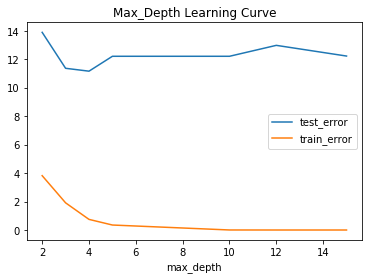

In [223]:
# Plot Max_Depth Learning Curve
max_depth_lr.plot(title="Max_Depth Learning Curve")

### 5b. Examine Learning_Rate Parameter

Explain Learning Rate:

In [224]:
# Reset results array
results = []

for learning_rate in [0.05,0.1,0.2,0.4,0.6,0.8,1]:
    clf = xgb.XGBRegressor(max_depth=2,learning_rate=learning_rate, n_estimators=200)
    clf.fit(X_train_2, y_train_2, eval_set=eval_set, verbose=False)
    results.append(
        {
            'learning_rate': learning_rate,
            'train_error': metrics.mean_squared_error(y_train_2, clf.predict(X_train_2)),
            'test_error': metrics.mean_squared_error(y_test_2, clf.predict(X_test_2))
        })
    
learning_rate_lr = pd.DataFrame(results).set_index('learning_rate').sort_index()
learning_rate_lr

,test_error,train_error
learning_rate,,
0.05,13.396981,3.941023
0.10,13.233431,2.400513
0.20,11.936768,1.157734
0.40,13.133068,0.342035
0.60,16.771368,0.115001
0.80,18.361069,0.069368
1.00,25.539554,0.041234


**Plot Learning Rate Learning Curve**

The best learning rate is 0.05

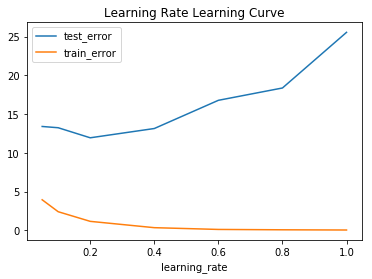

In [225]:
# Plot Learning Rate
learning_rate_lr.plot(title="Learning Rate Learning Curve")

### 5c. Explain N_Estimators Parameter

Explain n_estimators:
Unlike Random Forest, you can specify as much n_estimators because you're just taking the average. So the more the better (more generalizability)

For GBT, it's sequential. So you're prone to overfitting as you increase the amount of learning trees. Hence the graph.

In [232]:
# Reset results array
results = []

for n_estimators in [50,60,100,150,200,500,750,1000, 1500]:
    clf = xgb.XGBRegressor(max_depth=2,learning_rate=0.10, n_estimators=n_estimators)
    clf.fit(X_train_2, y_train_2, eval_set=eval_set, verbose=False)
    results.append(
        {
            'n_estimators': n_estimators,
            'train_error': metrics.mean_squared_error(y_train_2, clf.predict(X_train_2)),
            'test_error': metrics.mean_squared_error(y_test_2, clf.predict(X_test_2))
        })
    
n_estimators_lr = pd.DataFrame(results).set_index('n_estimators').sort_index()
n_estimators_lr

,test_error,train_error
n_estimators,,
50,16.173677,6.237241
60,15.133341,5.447760
100,13.893604,3.819446
150,13.475612,2.994603
200,13.233431,2.400513
500,12.860073,0.832688
750,13.095709,0.412516
1000,13.282228,0.223503
1500,13.411032,0.074901


**Plot N_Estimators Learning Curve**

Best N_Estimators is 50

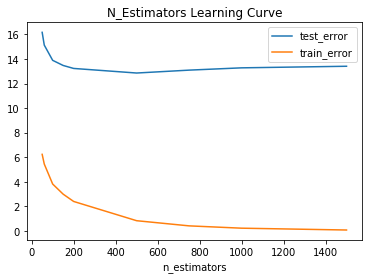

In [233]:
n_estimators_lr.plot(title="N_Estimators Learning Curve")

## 6. Perform GridSearchCV

1. Use Grid Search to find optimal parameters
2. After getting the optimal parameters, you can plot learning curve to see what is the best early_stopping (n rounds)

**GridSearch:** In grid-search, we start by defining a dictionary of possible parameter values we want to test. All combinations will be evaluated.

In [253]:
model = xgb.XGBRegressor()

In [255]:
# Define Parameters
param_grid = {"max_depth": [2,3,10],
              "max_features" : [1.0,0.3,0.1],
              "min_samples_leaf" : [3,5,9,17],
              "n_estimators": [100,500,1000],
              "learning_rate": [0.05,0.1,0.02,0.2]}

In [256]:
# Perform Grid Search CV
gs_cv = GridSearchCV(model, param_grid=param_grid, cv = 3, verbose=10, n_jobs=-1 ).fit(X_train_2, y_train_2)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   28.5s
[Paralle

In [252]:
# Best hyperparmeter setting
gs_cv.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, max_features=1.0, min_child_weight=1,
       min_samples_leaf=3, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

## 7. Plot Learning Curve

Let's use our best model parameters **above** from our GridSearchCV and plot our learning curve.

**Perform 1000 tree boosting rounds**

In [258]:
# Use our best model parameters found by GridSearchCV
best_model = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, max_features=1.0, min_child_weight=1,
       min_samples_leaf=3, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

Text(0.5,1,'XGBoost RMSE')

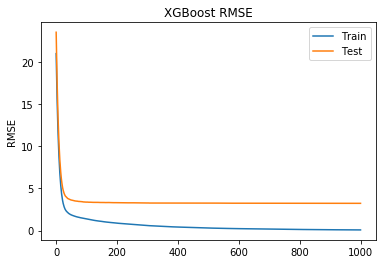

In [259]:
# Create eval_set
eval_set = [(X_train_2, y_train_2), (X_test_2, y_test_2)]

# Fit our model to the training set
best_model.fit(X_train_2, y_train_2, eval_set=eval_set, verbose=False)

# Make predictions with test data
y_pred = best_model.predict(X_test_2)
predictions = [round(value) for value in y_pred]

# Retrieve performance metrics
results = best_model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

# Plot log loss curve
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')

## 8. Early Stopping

**Here's the solution**:

Looks like our model starts to overfit after about 100 rounds.

Add in **'early_stopping_rounds'** as a parameter and it will allow you to find the sweet spot before your model starts to overfit

**Performing Early Stopping**: 
- We found that **n_estimators=61** was the best parameter where we should stop training at.
- Early Stopping is used because it allows you to see at what point does your model start overfitting
- It saves you lots of time and processing power

In [260]:
# Fit the training set and apply early stopping 
best_model.fit(X_train_2, y_train_2, early_stopping_rounds=10, eval_set=eval_set, verbose=True)

[0]	validation_0-rmse:20.9923	validation_1-rmse:23.5317
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:19.0232	validation_1-rmse:21.3639
[2]	validation_0-rmse:17.2442	validation_1-rmse:19.4812
[3]	validation_0-rmse:15.648	validation_1-rmse:17.7426
[4]	validation_0-rmse:14.2121	validation_1-rmse:16.1747
[5]	validation_0-rmse:12.9134	validation_1-rmse:14.7968
[6]	validation_0-rmse:11.7527	validation_1-rmse:13.5669
[7]	validation_0-rmse:10.701	validation_1-rmse:12.4708
[8]	validation_0-rmse:9.75232	validation_1-rmse:11.4475
[9]	validation_0-rmse:8.89436	validation_1-rmse:10.5483
[10]	validation_0-rmse:8.13114	validation_1-rmse:9.74896
[11]	validation_0-rmse:7.45103	validation_1-rmse:9.01264
[12]	validation_0-rmse:6.83713	validation_1-rmse:8.39079
[13]	validation_0-rmse:6.28409	validation_1-rmse:7.85062
[14]	validation_0-rmse:5.8005	validation_1-rmse:7.34988

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, max_features=1.0, min_child_weight=1,
       min_samples_leaf=3, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

## 9. Feature Importance

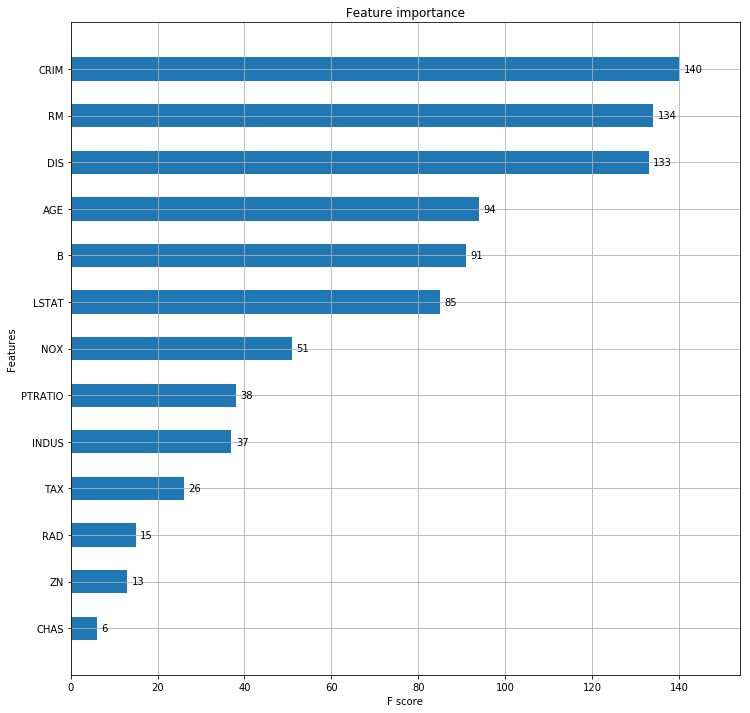

In [261]:
# Plot basic feature importance chart
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(best_model, height=0.5, ax=ax)
plt.show()

## Questions
***
1. What should we do if the error on train is higher as compared to error on test.
2. Apart for ealry stopping how can we tune regularization parameters effectively?
3. If your Gradient boosting ensemble overfits the training set, should you increase or decrease the learning rate?
4. What are some hyperparameters of gradient boosting that controls complexity of the model?
5. The good thing about Gradient Boosting is that it can be applied to any loss function. (T/F)
6. What technique can you use to find out when your Gradient Boosting model is overfitting the training data?
